In [64]:
#%pip install -r work/geometry-classifier/requirements.txt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

In [5]:
base_path = 'work/geometry-classifier/data/'

df = pd.read_csv(base_path+'photos_v1/photos_10.csv')

In [6]:
image_row = df.iloc[0, 1:].values

# Reshape the flattened row into a 2D array (for a 224x224 image)
image_reshaped = image_row.reshape(256, 256)

In [7]:
# converr to float
image_reshaped = image_reshaped.astype(float)

In [8]:
df.head()

,pyramid_35_0_0,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.63658,0.63659,0.63660,0.63661,0.63662,0.63663,0.63664,0.63665,0.63666,0.63667
0,pyramid_35_0_1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,pyramid_35_0_2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,pyramid_35_0_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pyramid_35_0_4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,pyramid_35_0_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


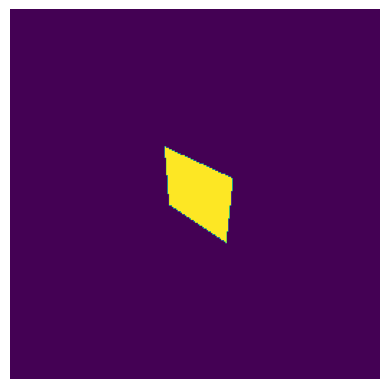

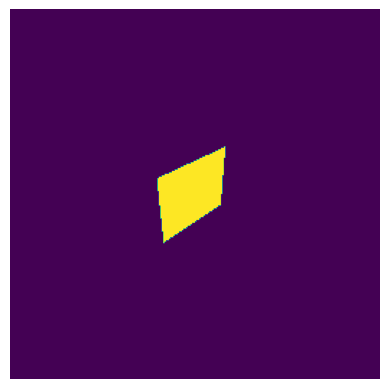

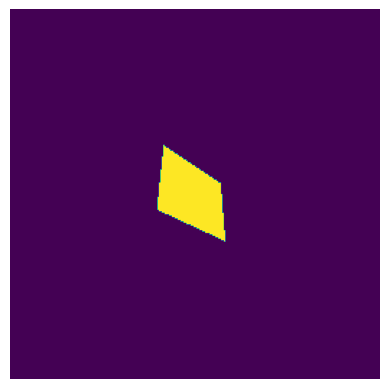

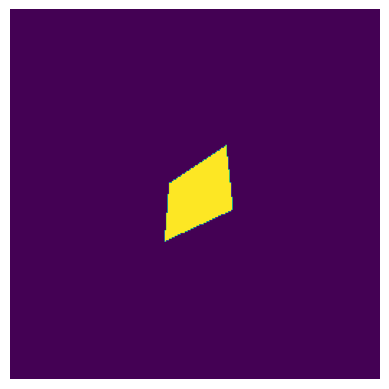

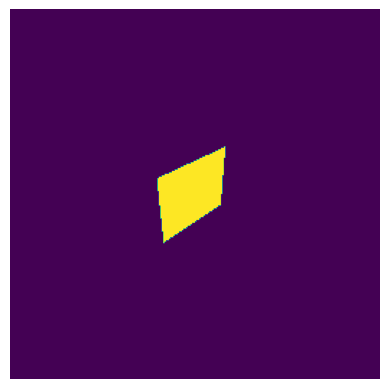

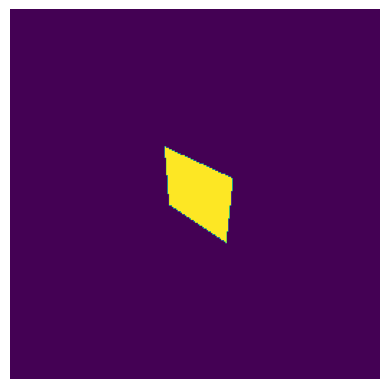

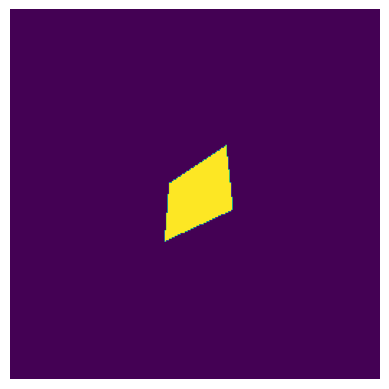

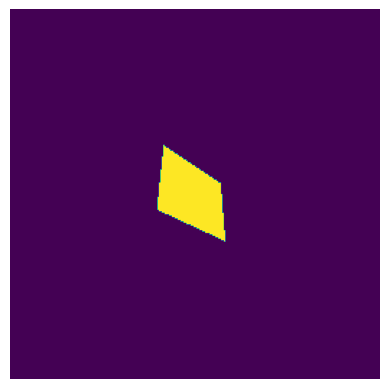

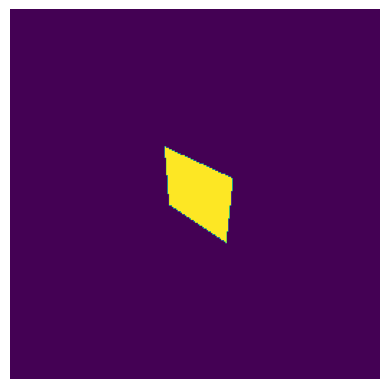

In [10]:

for i in range(1, 10):
    image_row = df.iloc[i, 1:].values
    image_reshaped = image_row.reshape(256, 256).astype(float)
    
    plt.imshow(image_reshaped)
    plt.axis('off')
    plt.show()

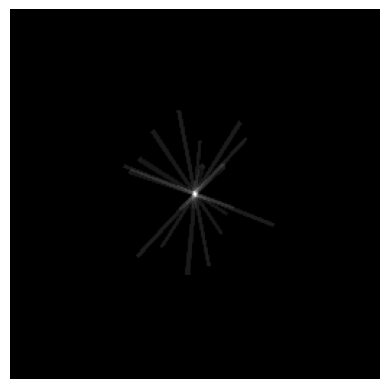

In [ ]:
#df = pd.DataFrame([[int(128)] * (256 * 256)])  # Example row with pixel values between 0 and 255


# Render the image using matplotlib
plt.imshow(image_reshaped, cmap='gray')  # Set vmin and vmax to handle the full 0-255 range
plt.axis('off')  # Optionally turn off the axis
plt.show()

In [11]:
df.head()

,pyramid_35_0_0,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.63658,0.63659,0.63660,0.63661,0.63662,0.63663,0.63664,0.63665,0.63666,0.63667
0,pyramid_35_0_1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,pyramid_35_0_2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,pyramid_35_0_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pyramid_35_0_4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,pyramid_35_0_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
#from sklearn.grid_search import GridSearchCV
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import applications as cnns
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

In [42]:
#list_of_models = []

"""
def create_model_VGG16(optimizer='adam'):
    model = cnns.VGG16(include_top=False, input_shape=(256, 256, 3))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_model_ResNet50(optimizer='adam'):
    model = cnns.ResNet50(include_top=False, input_shape=(256, 256, 3))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
"""

base_model = cnns.VGG16(include_top=True, weights="imagenet" ,input_shape=(224, 224, 3))
x = base_model.output
x = Flatten(name="custom_flatten")(x)
x = Dense(1024, activation="relu", name="custom_dense")(x)
pred = Dense(1000, activation="softmax", name="custom_pred")(x)


model = Model(inputs=base_model.input, outputs=pred)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [51]:
df_ranges = 3

results = []

for i in range(1, df_ranges):
    print("Csv number: ", i)
    df = pd.read_csv(base_path + 'photos_v1/photos_' + str(i) + '.csv')
    for image in df.iterrows():
        target = re.sub(r"(_.*)","",image[1][0])
        image_row = image[1][1:].values
        image_row = image_row.reshape(256, 256).astype(float)
        image_row = np.expand_dims(image_row, axis=-1)
        image_reshaped = smart_resize(image_row, (224, 224))
        image_reshaped = np.repeat(image_reshaped, 3, axis=-1)
        image_reshaped = np.expand_dims(image_reshaped, axis=0)
        results.append((model.predict(image_reshaped), target))
    del df


Csv number:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


/tmp/ipykernel_147/2342394350.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target = re.sub(r"(_.*)","",image[1][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/tmp/ipykernel_147/2342394350.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target = re.sub(r"(_.*)","",image[1][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

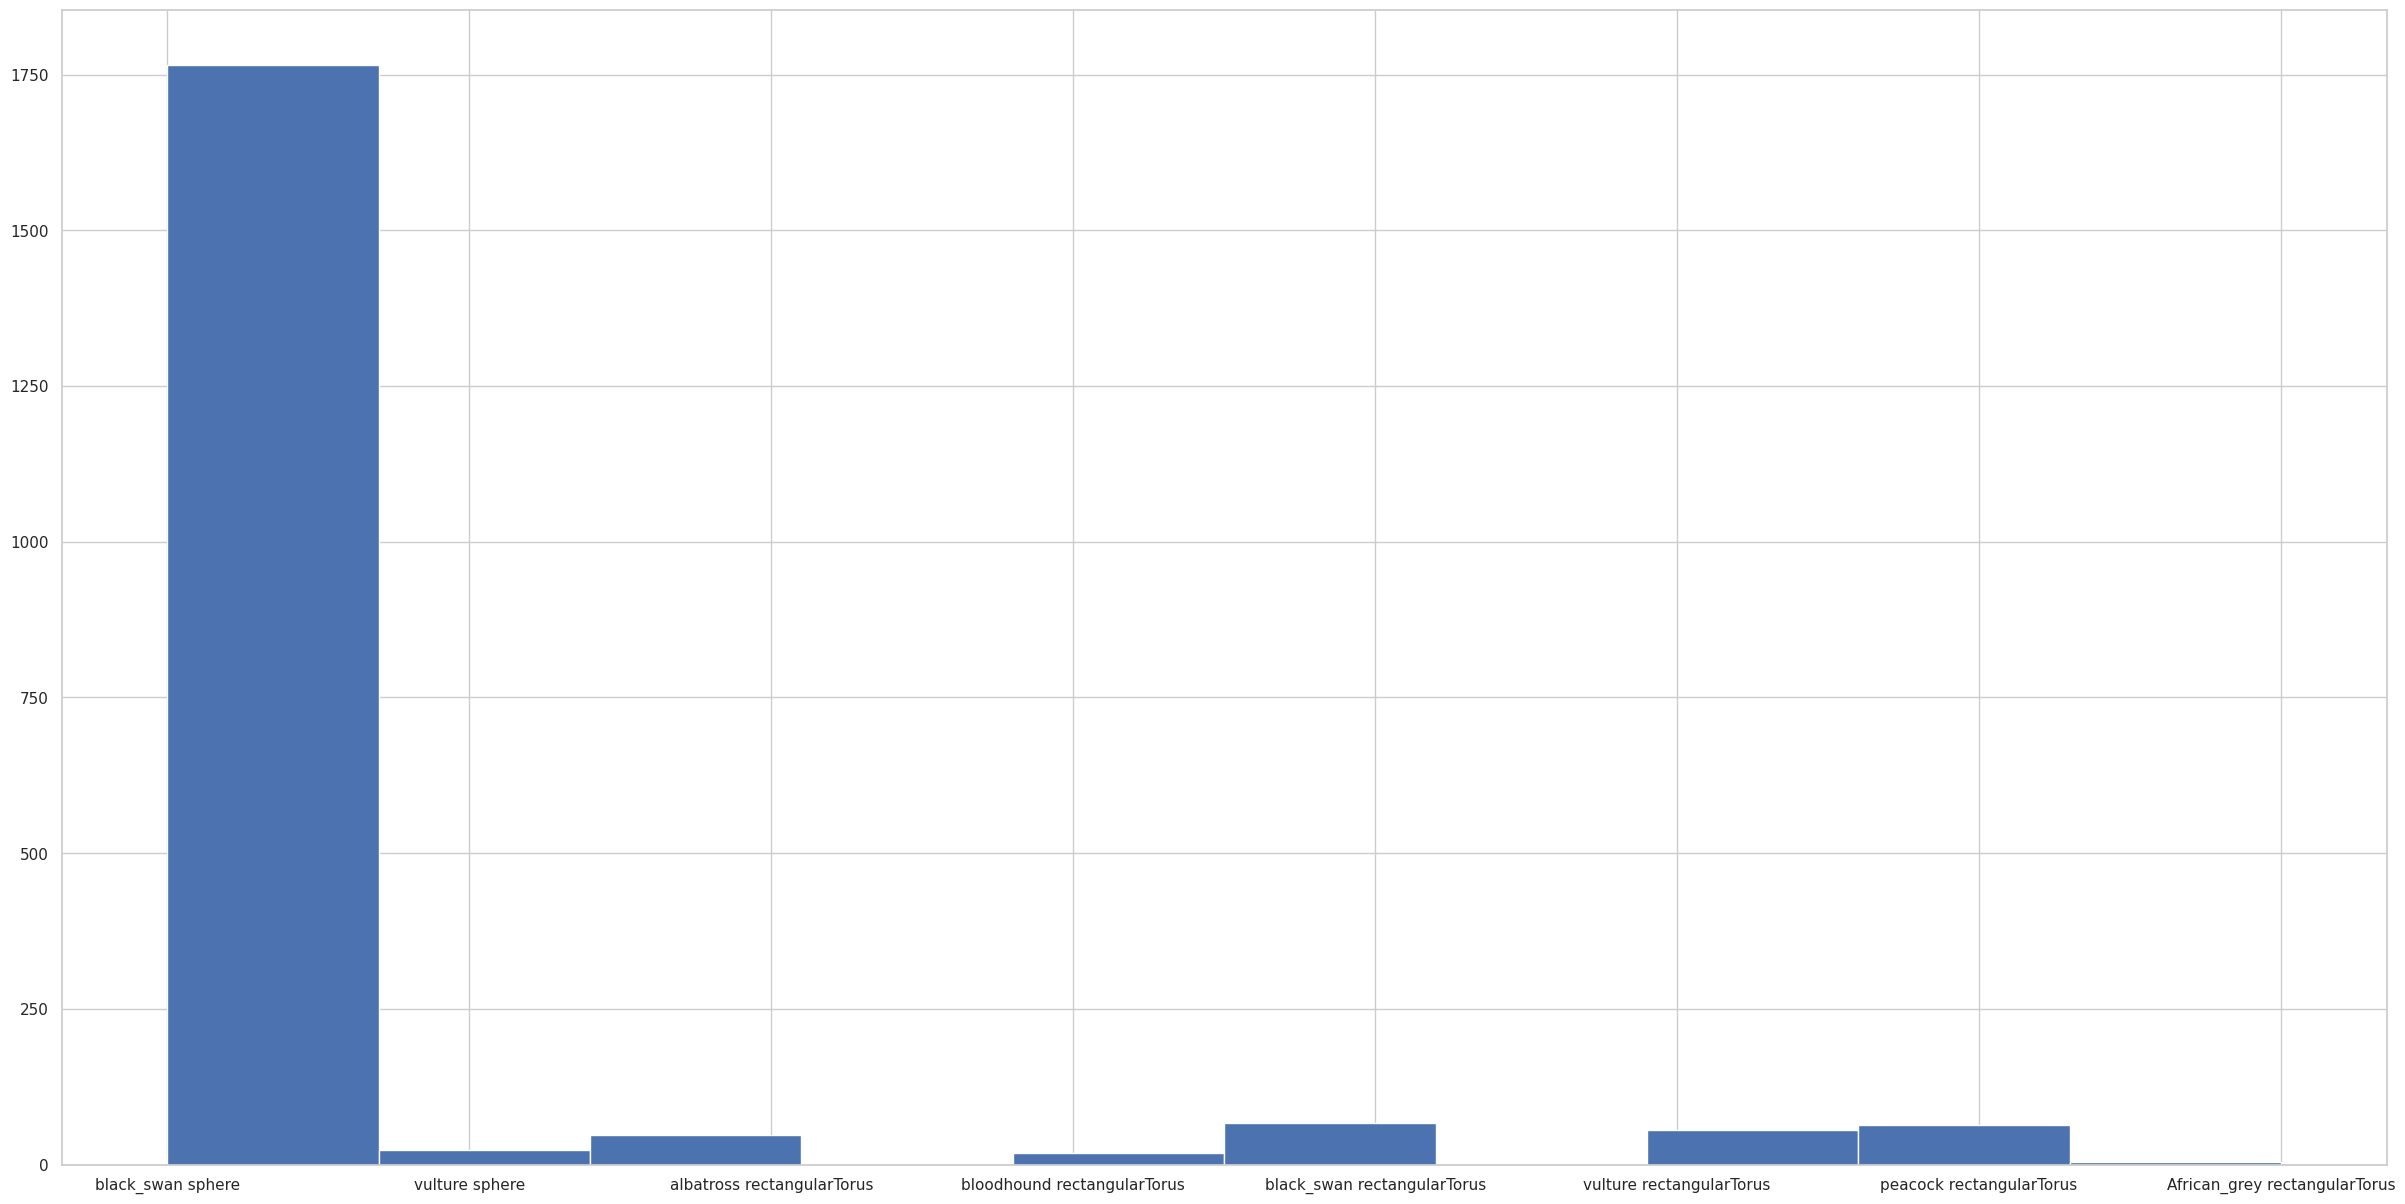

In [73]:
a = cnns.vgg16.decode_predictions(results[0][0], top=1)
decoder = cnns.vgg16.decode_predictions
results_decoded = [(decoder(res[0], top=1)[0][0][1],res[1]) for res in results]

decoded_for_plot = [str(res[0]) + " "+ str(res[1]) for res in results_decoded]

plt.figure(figsize=(30, 15))
plt.hist(decoded_for_plot)
plt.show()
